# Projekt zaliczeniowy
## Temat: 
Klasyfikacja sztućców za pomocą metody k-średnich
## Autor:
Klara Dargacz

Import pakietów:

In [ ]:
from skimage import (io, color, morphology, filters, data, exposure, segmentation, measure)
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology

In [ ]:
def plot(img, is_color=False):
    plt.figure(figsize=(8,8))
    if is_color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = plt.cm.gray)
        
def plot_subplots(img1, img2):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap = plt.cm.gray)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap = plt.cm.gray)
    plt.show()

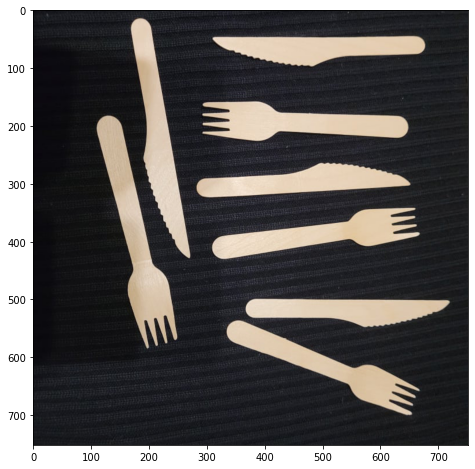

In [ ]:
img = io.imread('papierowy.png')
plot(img, True)

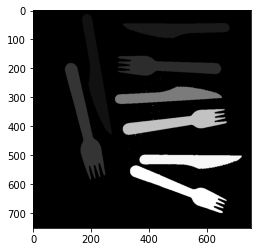

In [ ]:
# obróbka zdjęcia

img_gray = color.rgb2gray(img)

img_equalized = exposure.equalize_adapthist(img_gray)
img_equalized = (img_equalized*255).astype('uint8')

img_filtered = filters.rank.mean(img_equalized, np.ones([1,1]))

threshold = filters.threshold_otsu(img_filtered)
img_bin = img_filtered > threshold

img_cleared_borders = segmentation.clear_border(img_bin)

img_opened = morphology.binary_opening(img_cleared_borders, np.ones([1,1]))

img_preprocessed = morphology.binary_closing(img_opened, np.ones([5,5]))

img_labeled = measure.label(img_preprocessed, connectivity=2)


plt.imshow(img_labeled, cmap = plt.cm.gray)


Histogram obrazu

Cechy:

In [ ]:
regionprops = measure.regionprops(img_labeled)
indeksy_obiektow = []
for i in range (len(regionprops)):
  if regionprops[i].area > 100:
    indeksy_obiektow.append(i)
indeksy_obiektow

[1, 2, 4, 5, 13, 21, 27, 28]

In [ ]:
def calc_roundness(area, perimeter):
    return (4*np.pi*area)/perimeter**2

In [ ]:
a=[[],[],[],[],[],[],[],[]]

for r in range(8):
    a[r].append(calc_roundness(regionprops[indeksy_obiektow[r]].area, regionprops[indeksy_obiektow[r]].perimeter))
    a[r].append(regionprops[indeksy_obiektow[r]].eccentricity)
a

[[0.22098359266338577, 0.9942643849092402],
 [0.26138506587970606, 0.9920572447651973],
 [0.16734732128088123, 0.9894105689753727],
 [0.15191125445316553, 0.9913896406059343],
 [0.24998033540724426, 0.9932198560340963],
 [0.16379494745072526, 0.9913615271053996],
 [0.25934723791900555, 0.9929362489475179],
 [0.16856429196219097, 0.9911846319215227]]

In [ ]:
b = []
for i in range(8):
  b.append(np.array(a[i]))
b

[array([0.22098359, 0.99426438]),
 array([0.26138507, 0.99205724]),
 array([0.16734732, 0.98941057]),
 array([0.15191125, 0.99138964]),
 array([0.24998034, 0.99321986]),
 array([0.16379495, 0.99136153]),
 array([0.25934724, 0.99293625]),
 array([0.16856429, 0.99118463])]

Grupowanie

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(b)
y_kmeans = kmeans.predict(b)

In [ ]:
for i in range(0,2):
  row = np.where(y_kmeans==i)[0] 
  num = row.shape[0]       #  liczba elementów w klastrach
  
  print("cluster "+str(i))
  print(str(num)+" elements")

cluster 0
4 elements
cluster 1
4 elements


In [ ]:
y_kmeans

array([1, 1, 0, 0, 1, 0, 1, 0], dtype=int32)

In [ ]:
fig = px.imshow(img)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(img_labeled)
type = ['widelec', 'nóż']


for i in range(len(indeksy_obiektow)):
  label_i = props[indeksy_obiektow[i]].label
  contour = measure.find_contours(img_labeled == label_i, 0.5)[0]
  y, x = contour.T
  hoverinfo = ''
  hoverinfo += f'<b>{"typ"}: {type[y_kmeans[i]]}</b><br>'


  if y_kmeans[i] == 0:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'seashell', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))
  else:
    fig.add_trace(go.Scatter(
          x=x, y=y, name=indeksy_obiektow[i],
          mode='none', fill='toself',fillcolor = 'magenta', showlegend=False, hovertemplate=hoverinfo, hoveron='points+fills'))


  
plotly.io.show(fig)